In [ ]:
"""
A simple test to check if the RFAE model loads and runs properly
on toy datasets, producing train/test embeddings.
"""

from rfae import RFAE
from sklearn.datasets import fetch_openml, load_digits
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np

# Loading functions

In [2]:
def load_dataset(data_name="optdigits", subsample_size=None, random_state=42):

    # Load full dataset
    if data_name == "mnist":
        mnist = fetch_openml(data_id=554, as_frame=False)
        x = mnist.data.astype(float)
        y = mnist.target.astype(int)

    elif data_name == "fmnist":
        fmnist = fetch_openml(data_id=40996, as_frame=False)
        x = fmnist.data.astype(float)
        y = fmnist.target.astype(int)

    elif data_name == "usps":
        usps = fetch_openml(data_id=41082, as_frame=False)
        x = usps.data.astype(float)
        y = usps.target.astype(int)

    elif data_name == "optdigits":
        digits = load_digits()
        x = digits.data.astype(float)
        y = digits.target.astype(int)

    elif data_name == "coil20":
        coil = fetch_openml(data_id=40979, as_frame=False)
        x = coil.data.astype(float)
        y = coil.target.astype(int)

    else:
        raise ValueError(f"Unknown dataset: {data_name}")

    print(f"Loaded {data_name}: X={x.shape}, y={y.shape}")

    # Optional stratified subsample BEFORE train/test split
    if subsample_size is not None and subsample_size < len(y):
        sss = StratifiedShuffleSplit(
            n_splits=1,
            train_size=subsample_size,
            random_state=random_state
        )
        idx_sub, _ = next(sss.split(x, y))
        x = x[idx_sub]
        y = y[idx_sub]
        print(f"Stratified subsample: {x.shape[0]} samples retained.")

    return x, y

# Load data

In [3]:
data_name = "mnist"
x, y = load_dataset(data_name, subsample_size=20000)

print(f"Final dataset: Samples={len(x)}, Features={x.shape[1]}")

Loaded mnist: X=(70000, 784), y=(70000,)
Stratified subsample: 20000 samples retained.
Final dataset: Samples=20000, Features=784



# Split into train/test sets


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize and fit RFAE


In [5]:
model = RFAE(
    n_components=2,
    epochs=200,
    lam=0.01,
    recon_loss_type='kl',
    n_prototypes=5000,
    random_state=42
    )


emb_train = model.fit_transform(x_train, y_train)
emb_test = model.transform(x_test)

print("Embedding shapes:", emb_train.shape, emb_test.shape)

2025-11-18 21:25:30,998 - INFO - Using device: mps


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.1s finished


[get_proximities], batch_size=320, n_rows=16000, n_batches=50
[get_proximities] 1/50 rows 0→320
[get_proximities] 2/50 rows 320→640
[get_proximities] 3/50 rows 640→960
[get_proximities] 4/50 rows 960→1280
[get_proximities] 5/50 rows 1280→1600
[get_proximities] 6/50 rows 1600→1920
[get_proximities] 7/50 rows 1920→2240
[get_proximities] 8/50 rows 2240→2560
[get_proximities] 9/50 rows 2560→2880
[get_proximities] 10/50 rows 2880→3200
[get_proximities] 11/50 rows 3200→3520
[get_proximities] 12/50 rows 3520→3840
[get_proximities] 13/50 rows 3840→4160
[get_proximities] 14/50 rows 4160→4480
[get_proximities] 15/50 rows 4480→4800
[get_proximities] 16/50 rows 4800→5120
[get_proximities] 17/50 rows 5120→5440
[get_proximities] 18/50 rows 5440→5760
[get_proximities] 19/50 rows 5760→6080
[get_proximities] 20/50 rows 6080→6400
[get_proximities] 21/50 rows 6400→6720
[get_proximities] 22/50 rows 6720→7040
[get_proximities] 23/50 rows 7040→7360
[get_proximities] 24/50 rows 7360→7680
[get_proximities] 25

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.0s finished


[prox_extend], batch_size=100, n_rows=4000, n_batches=40
[prox_extend] 1/40 rows 0→100
[prox_extend] 2/40 rows 100→200
[prox_extend] 3/40 rows 200→300
[prox_extend] 4/40 rows 300→400
[prox_extend] 5/40 rows 400→500
[prox_extend] 6/40 rows 500→600
[prox_extend] 7/40 rows 600→700
[prox_extend] 8/40 rows 700→800
[prox_extend] 9/40 rows 800→900
[prox_extend] 10/40 rows 900→1000
[prox_extend] 11/40 rows 1000→1100
[prox_extend] 12/40 rows 1100→1200
[prox_extend] 13/40 rows 1200→1300
[prox_extend] 14/40 rows 1300→1400
[prox_extend] 15/40 rows 1400→1500
[prox_extend] 16/40 rows 1500→1600
[prox_extend] 17/40 rows 1600→1700
[prox_extend] 18/40 rows 1700→1800
[prox_extend] 19/40 rows 1800→1900
[prox_extend] 20/40 rows 1900→2000
[prox_extend] 21/40 rows 2000→2100
[prox_extend] 22/40 rows 2100→2200
[prox_extend] 23/40 rows 2200→2300
[prox_extend] 24/40 rows 2300→2400
[prox_extend] 25/40 rows 2400→2500
[prox_extend] 26/40 rows 2500→2600
[prox_extend] 27/40 rows 2600→2700
[prox_extend] 28/40 rows 270

# Visualization

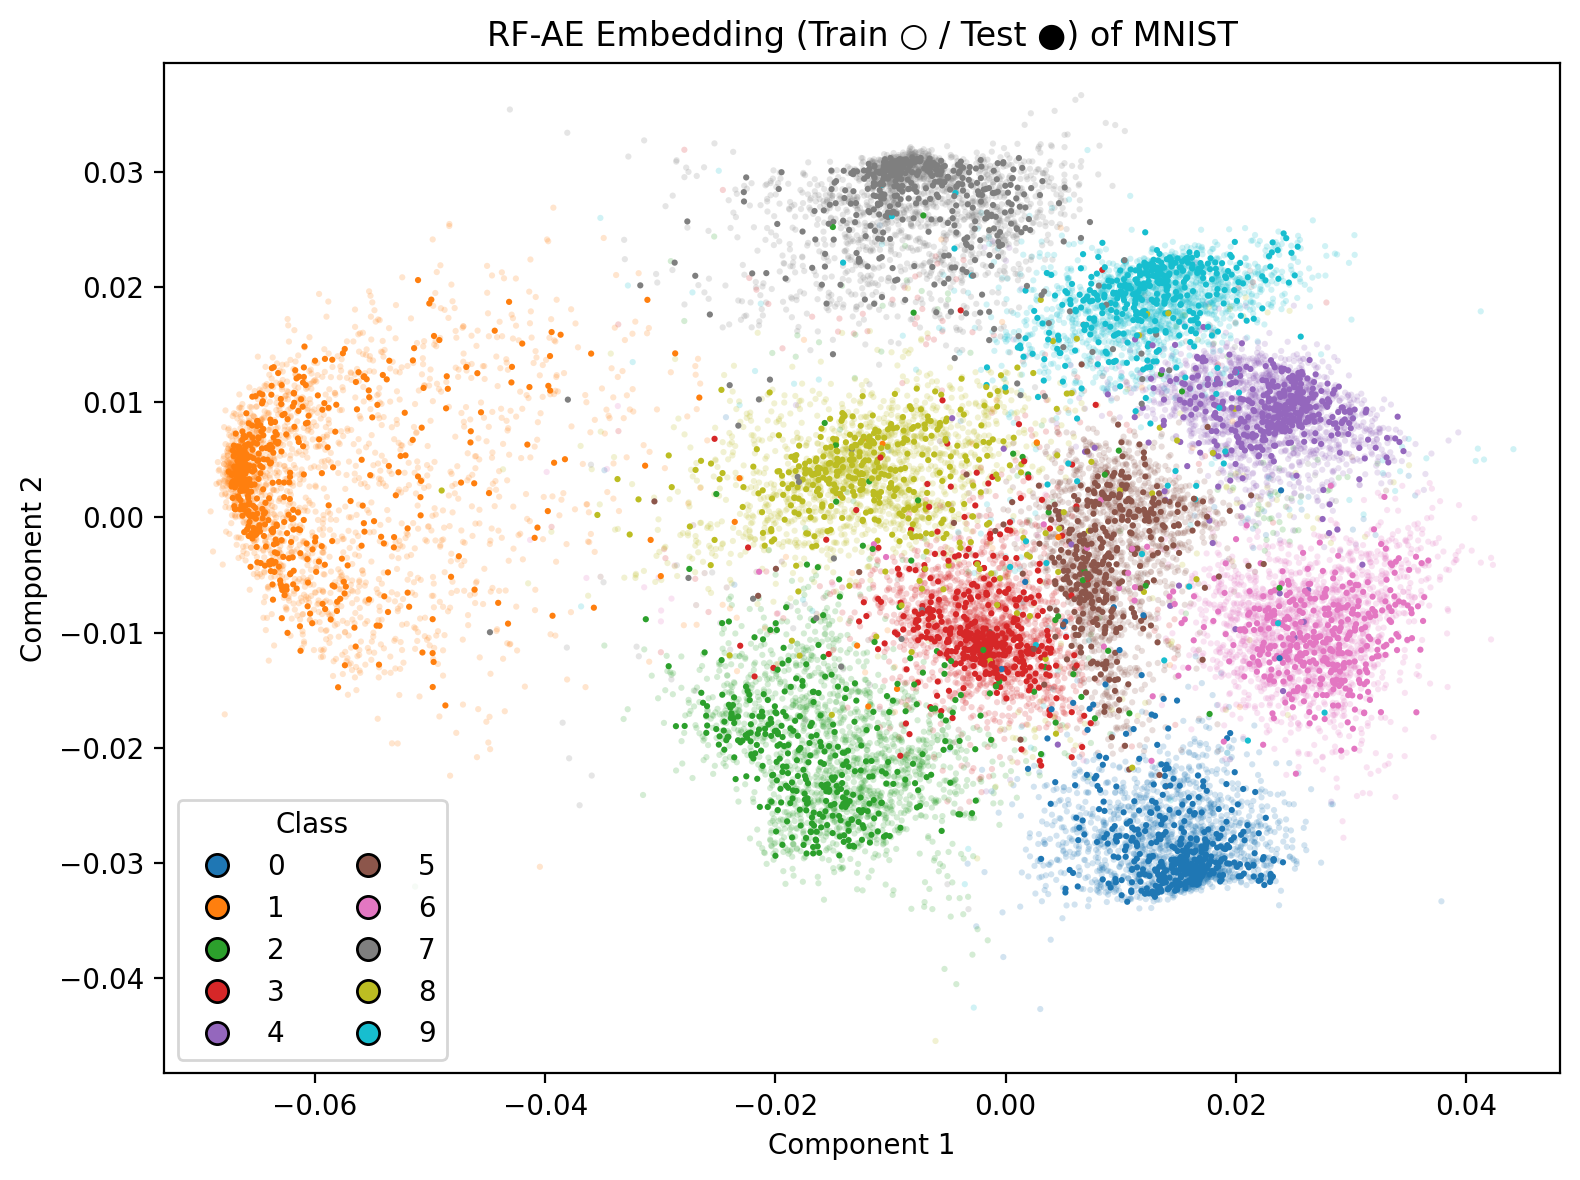

In [6]:
plt.figure(figsize=(8, 6), dpi=200)

# Plot training (circles) and test (triangles)
train_scatter = plt.scatter(
    emb_train[:, 0], emb_train[:, 1],
    c=y_train, cmap='tab10',
    s=5, alpha=0.2, marker='o', linewidths=0
)
test_scatter = plt.scatter(
    emb_test[:, 0], emb_test[:, 1],
    c=y_test, cmap='tab10',
    s=5, alpha=1, marker='o', linewidths=0
)

plt.title("RF-AE Embedding (Train ○ / Test ●) of " + data_name.upper())
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.axis("equal")

# Create dot-based legend: one dot per class (color-coded)
classes = np.unique(np.concatenate([y_train, y_test]))
cmap = plt.get_cmap('tab10')
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='none',
        markerfacecolor=cmap(i % 10),
        markersize=8,
        label=str(cls)
    )
    for i, cls in enumerate(classes)
]

plt.legend(
    handles=handles,
    title="Class",
    loc='best',
    frameon=True,
    ncol=2
)

plt.tight_layout()
plt.show()